# System configuration

In [1]:
!git clone https://github.com/inkyubeytor/explainability-challenges.git

fatal: destination path 'explainability-challenges' already exists and is not an empty directory.


In [2]:
!pip3 install torch torchvision torchaudio torchattacks datasets matplotlib

# Preamble

In [3]:
import sys
import torch
import numpy as np
import torchvision
sys.path.insert(1, "./explainability-challenges/src/")

import matplotlib.pyplot as plt
from datasets import load_dataset
from torchvision import transforms
from explainability.image.image_attacks import blur_attack, dual_class_attack, \
    noise_attack, occlusion_attack, ood_attack, adversarial_attack

/opt/homebrew/Caskroom/miniconda/base/envs/10713_test/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor()
])

def huggingface_to_tensor(image_list):
    image_array_list = [transform(image.convert('RGB')) for image in image_list]
    #image_array = np.stack(image_array_list, dim=0)

    return torch.stack(image_array_list)

In [5]:
dataset = load_dataset("frgfm/imagenette", "full_size", split="validation")
ood_dataset = huggingface_to_tensor(load_dataset("frgfm/imagewoof", "full_size", split="validation")['image'])
far_ood_dataset = huggingface_to_tensor(load_dataset("jbarat/plant_species", split='train')['image'])

Found cached dataset imagenette (/Users/jrast/.cache/huggingface/datasets/frgfm___imagenette/full_size/1.0.0/38929285b8abcae5c1305418e9d8fea5dd6b189bbbd22caba5f5537c7fa0f01f)
Found cached dataset imagewoof (/Users/jrast/.cache/huggingface/datasets/frgfm___imagewoof/full_size/1.0.0/27966bf439ec61d39fbb620b6c493290e3f75307ab7a7b4d979c61cfe5237a48)
Found cached dataset parquet (/Users/jrast/.cache/huggingface/datasets/jbarat___parquet/jbarat--plant_species-efbaed60a3c7fd6e/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


# Exploring image attacks

In [6]:
def show_image(img):
    img = img.squeeze().permute(1,2,0)
    plt.imshow(img)

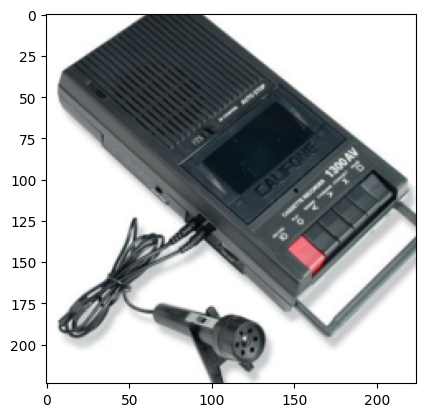

In [7]:
img = dataset[0]['image']
img = image = (transform(img) * 255).int().float()

show_image(img / 255)

## Noise attack

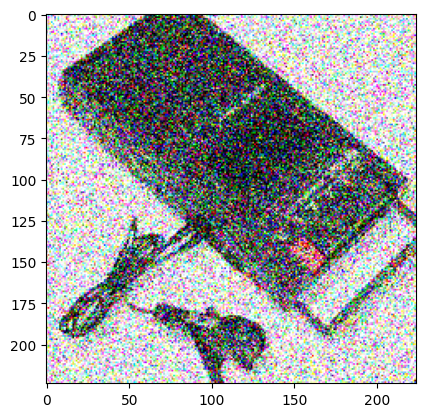

In [8]:
noisy_img = noise_attack(img, std=100)

show_image(noisy_img / 255)

## Blur attack

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


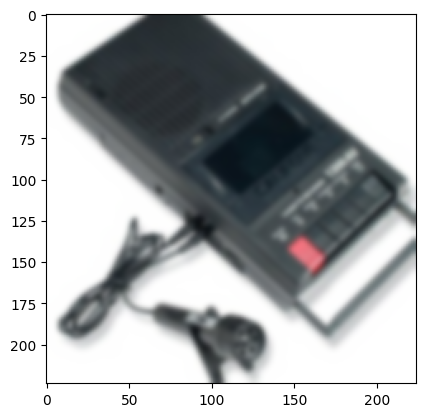

In [9]:
blurry_img = blur_attack(img)

show_image(blurry_img)

# Occlusion attack

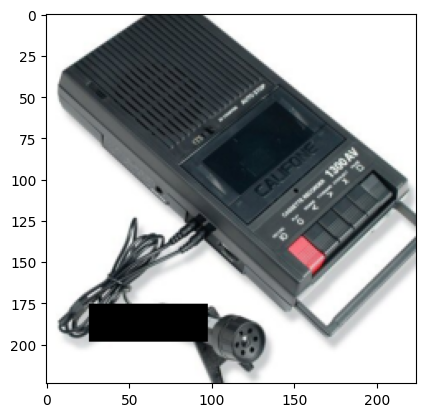

In [10]:
occluded_img = occlusion_attack(img)

show_image(occluded_img)

## Dual class attack

In [11]:
def dual_class_attack(image, dataset, loc=None):
    to_pil = torchvision.transforms.ToPILImage()
    to_tensor = torchvision.transforms.ToTensor()
    i = torch.randint(len(dataset), size=(1, 1))[0]
    foreground = to_pil(ood_dataset[i].squeeze()).convert("RGBA")
    background = to_pil(image.squeeze() / 255).convert("RGBA")
    bg_size = background.size
    new_size = int(bg_size[0] / 3)

    if loc == None:
        loc1 = torch.randint(int(2 * bg_size[0] / 3), size=(1, 1))[0]
        loc2 = torch.randint(int(2 * bg_size[0] / 3), size=(1, 1))[0]
        loc = (loc1, loc2)

    foreground = foreground.resize((new_size, new_size))
    background.paste(foreground, loc, foreground)
    background = background.convert("RGB")

    return to_tensor(background)

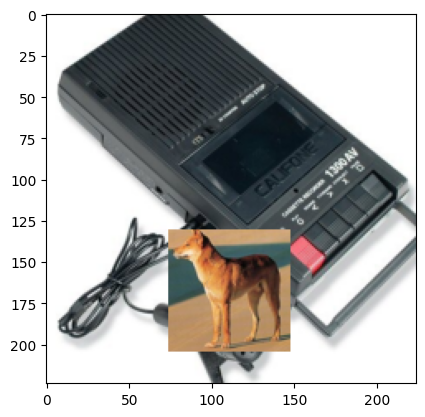

In [12]:
dual_class_img = dual_class_attack(img, ood_dataset)

show_image(dual_class_img)

## OOD attack

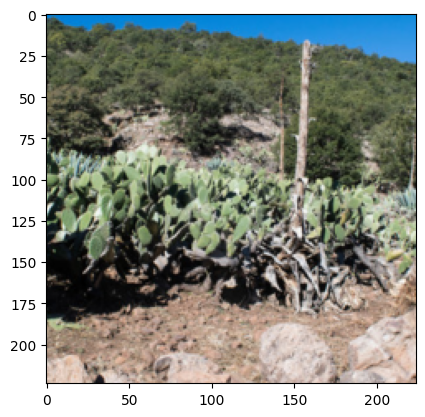

In [13]:
ood_img = ood_attack(far_ood_dataset)

show_image(ood_img * 255)

## Adversarial attack

In [14]:
from torchattacks import PGD
from torchvision import models

In [15]:
def adversarial_attack(image, model=models.resnet50(pretrained=True).to('cpu').eval(), get_class=False):
    label = torch.nn.functional.softmax(model(image.to('cpu'))).argmax()
    label = label.unsqueeze(dim=0)
    atk = PGD(model, eps=8/255, alpha=2/225, steps=10, random_start=True)
    #atk.set_normalization_used(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    output = atk(image, label).cpu()

    if get_class:
        return (output, int(model(image).argmax(dim=1)), int(model(output).argmax(dim=1)))
    return output

/opt/homebrew/Caskroom/miniconda/base/envs/10713_test/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/10713_test/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [16]:
data = huggingface_to_tensor(dataset['image'])

/var/folders/8p/2z59zpj94l51d20j4wt3hdnr0000gn/T/ipykernel_15309/476695496.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  label = torch.nn.functional.softmax(model(image.to('cpu'))).argmax()


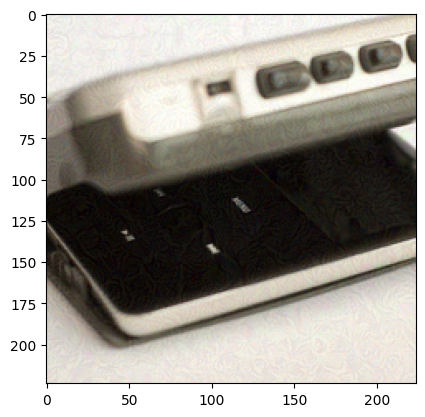

In [17]:
adversarial_image = adversarial_attack(data[25:26])
show_image(adversarial_image)

In [18]:
_, old_class, new_class = adversarial_attack(data[25:26], get_class=True)

print(old_class)
print(new_class)

/var/folders/8p/2z59zpj94l51d20j4wt3hdnr0000gn/T/ipykernel_15309/476695496.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  label = torch.nn.functional.softmax(model(image.to('cpu'))).argmax()


662
508
